In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

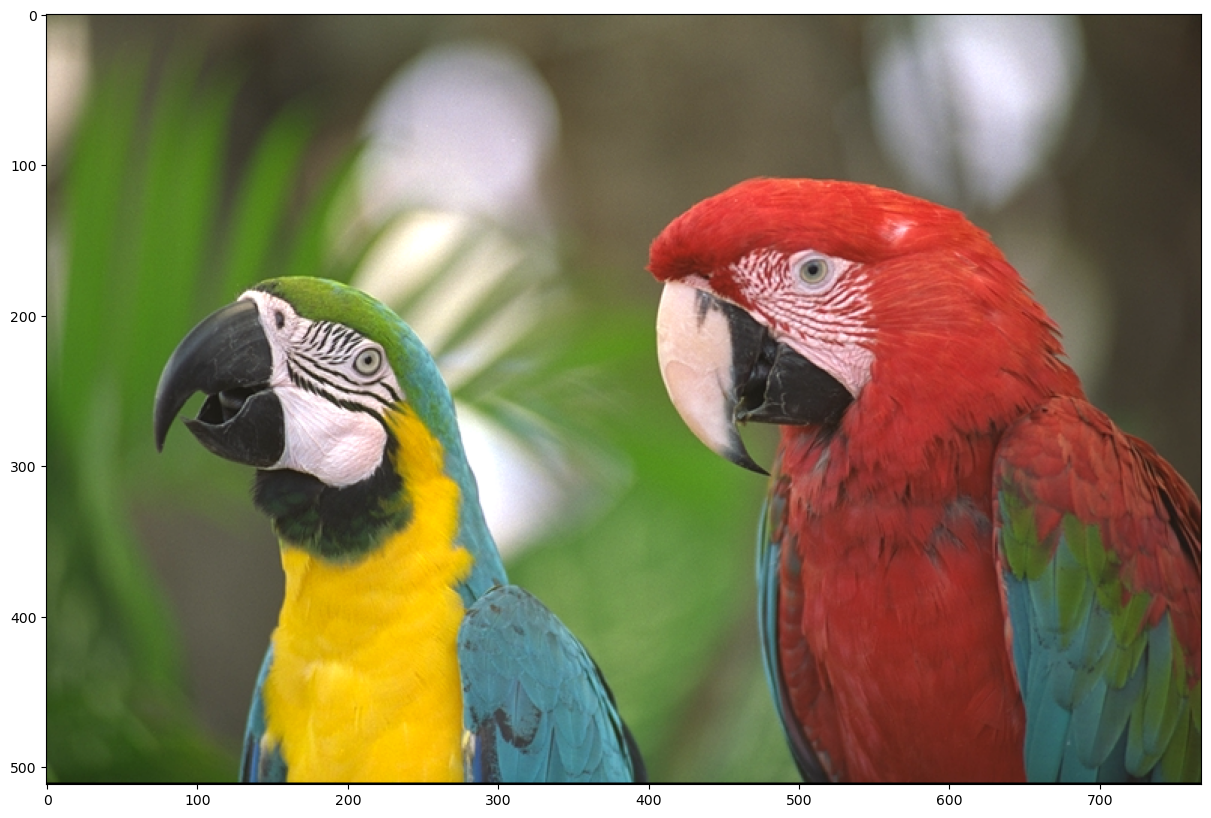

In [2]:
# Load image
img = cv2.imread('desktop/desktop/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

In [4]:
# Cast the image to float
img = img.astype(float)
palette = np.array([[0, 0, 0], [255, 255, 255], [200, 200, 200]])
# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]

        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.sqrt(np.sum((palette - pixel) ** 2, axis=1))
        closest_index = np.argmin(distances)
        
        new_pixel =  palette[closest_index]
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

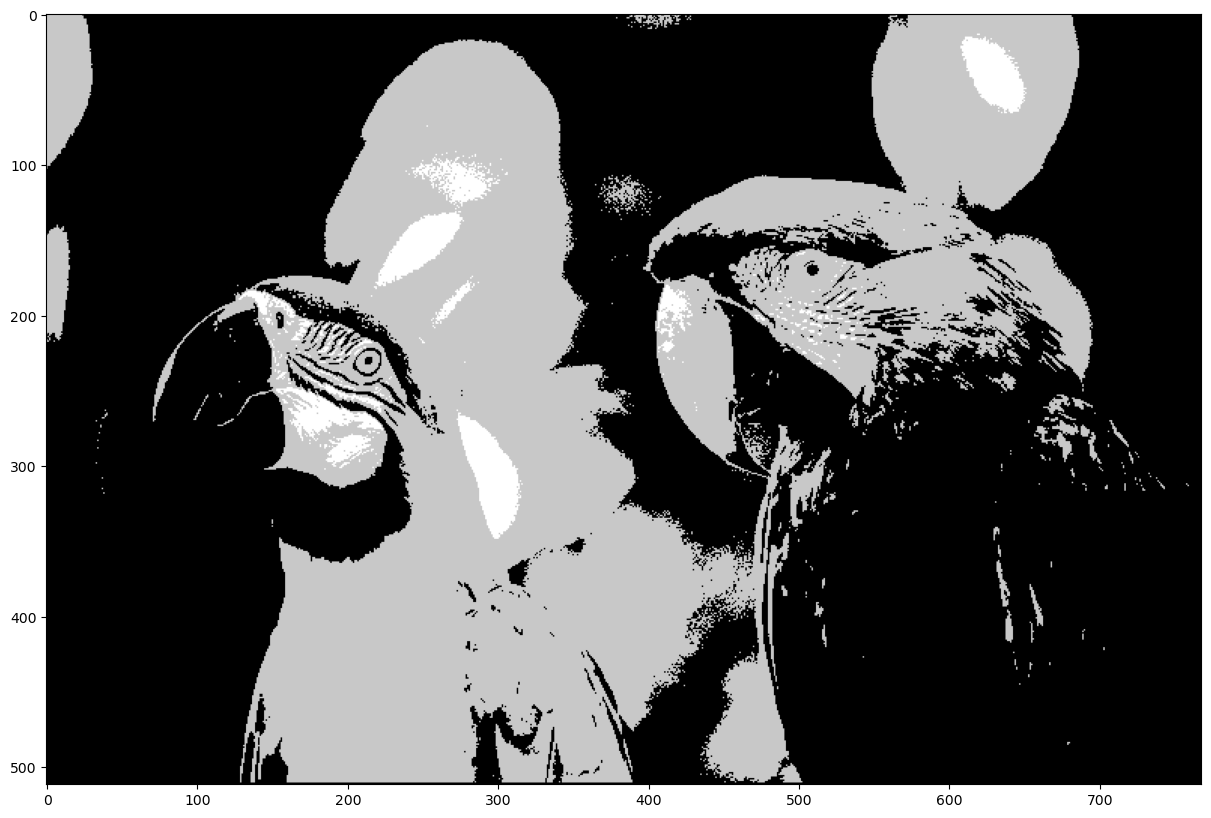

In [5]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized.astype(np.uint8))

In [6]:
# Compute average quantization error
quantization_error = np.abs(img - quantized)
avg_quant_error = np.mean(quantization_error)
print(f'Average Quantization Error: {avg_quant_error}')

Average Quantization Error: 70.29326290554471


In [7]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)
fs_diffusion_matrix = np.array([[0, 0, 7], [3, 5, 1]]) / 16  # Normalize by 16

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r,c,:]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distance = np.sqrt(np.sum((palette - pixel) ** 2, axis=1))
        close_index = np.argmin(distance)
        new_pixel = palette[close_index]
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        for dr in range(-1, 2):
            for dc in range(-1, 2):
                weight = fs_diffusion_matrix[dr - 1, dc - 1]
                img_tmp[r + dr, c + dc, :] += quant_error * weight
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x205e36cced0>)

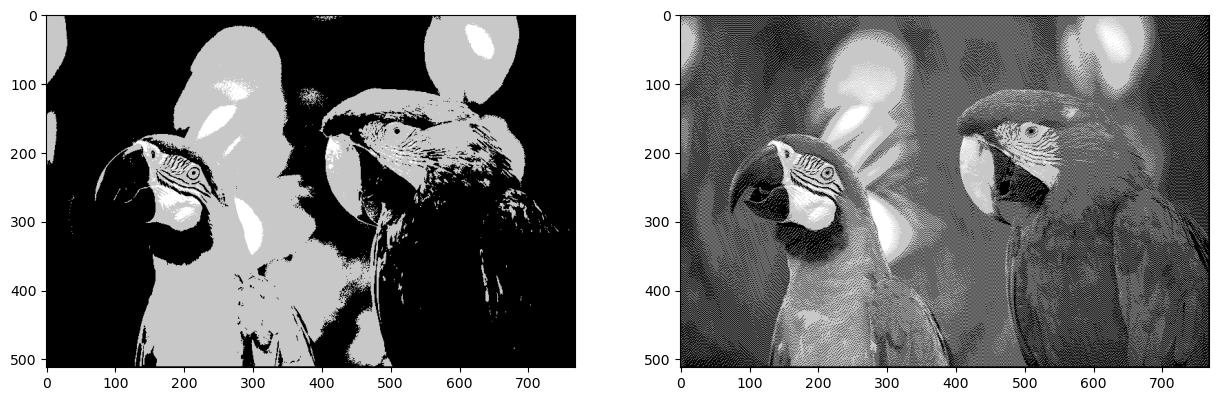

In [12]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(dithering.astype(np.uint8))   # dithering

In [14]:
# Compute average quantization error for dithered image
quantization_error = img.astype(np.float32) - dithering.astype(np.float32)
avg_dith_error = np.mean(np.abs(quantization_error))
print(f"Средняя ошибка квантизации для дизеризованного изображения: {avg_dith_error}")

Средняя ошибка квантизации для дизеризованного изображения: 82.85502624511719


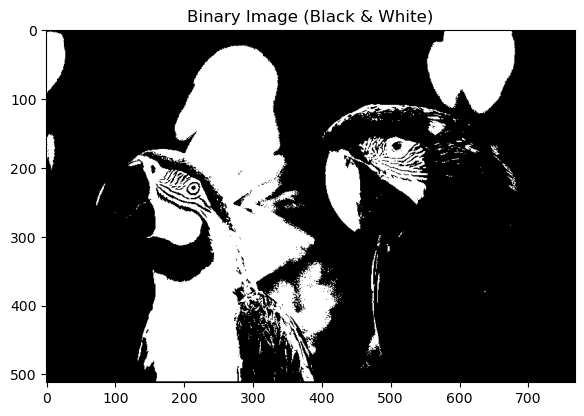

In [32]:
#ОТВЕТЫ НА ВОПРОСЫ

#Which image has higher quantization error? Optimally quantized or dithered?
#В основном, квантизированые изображения без оптимального квантирования имеет более высокую ошибку квантизации по сравнению с дизированным изображением,
#поскольку дизирование распределяет ошибку визуально, позволяя сделать более мягкую градацию цветов даже с ограниченным их количеством.

#Which image looks better to you?
#Дизированое изображение, поскольку оно более похоже на оригинал по сравнению с оптимально квантизированным изображением

#Can you repeat the same process using only two colours: black and white?
#Для создание черно-белого изображения использую пороговую функцию 
from PIL import Image
img = Image.open('desktop/desktop/kodim23.png').convert("L") 
array=np.array(img)
threshold = 128
binary_img = (array > threshold) * 255
plt.subplot(122), plt.imshow(binary_img, cmap='gray'), plt.title('Binary Image (Black & White)')
plt.show()

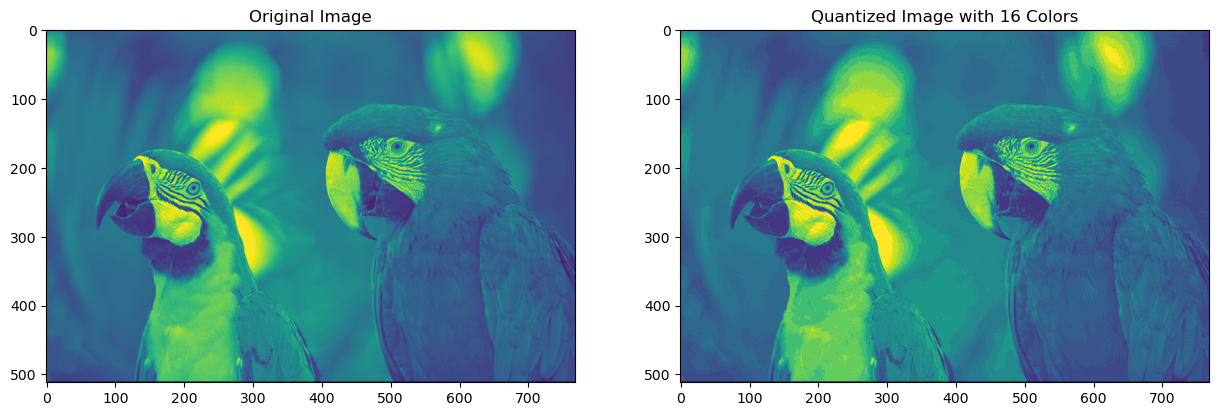

In [47]:
                                                   #BONUS POINTS

from sklearn.cluster import KMeans

img = Image.open('desktop/desktop/kodim23.png').convert("L") 
array=np.array(img)

img_reshaped = array.reshape(-1, array.shape[-1])

kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_

labels = kmeans.labels_

quantized_img = colors[labels].reshape(array.shape)

plt.subplot(121), plt.imshow(array), plt.title('Original Image')
plt.subplot(122), plt.imshow(quantized_img), plt.title('Quantized Image with 16 Colors')
plt.show()